# There is no plan bee without them 🐝

## Abstract
Pollinators around the world play a central role in our agriculture with an estimated economic benefit of €235bn per year. Up to 75% of our crops are dependent on pollination and honeybees account for most of it. Yet, in Europe and the USA the bee population has been declining at an alarming rate during the last decades. As by-hand pollination is not an alternative, it is impossible to imagine a world without them. [1]

With this project, we first aim at giving insights about the state of bee health and honey produced and traded using the [FAO datasets](http://www.fao.org/faostat/en/#data). Secondly, we focus on the USA using results from [US Departement of Agriculture](https://quickstats.nass.usda.gov/) in order to identify and present the main factors of bee decline. Finally, we propose a case study about almonds in California to show the consequences of a lack of bees.

[[1](http://sos-bees.org/wp-content/uploads/2014/04/BeesInDecline.pdf)] *Bees in Decline*, Greenpeace, 2013



In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## 1. How do the continents compare in terms of bee decline from 1961 to these days?

Robin

## 2. How do changes in honey production relate to number of beehives in Europe and the USA?

Robin

## 3. What are the consequences of bee decline on the patterns of honey import/export around the world?

Eric

# 4. US Case Study: Colony Collapse Disorder (CCD)

The cause (or causes) of **Colony Collapse Disorder (CCD)** is not quite clear. It is thought to have several plausible causes, including:

- Pesticide use
- Environmental stresses
- Bee pests (most specifically the Varroa)

In this section, we investigate the influence of bee pests.

In [61]:
loss_all = pd.read_excel("data/Bee Colony Loss.xlsx")
varroa_all = pd.read_csv("data/USDA_varroa.csv")

In [62]:
# State codes
states = {'alaska': 'AK',
 'alabama': 'AL',
 'arkansas': 'AR',
 'american samoa': 'AS',
 'arizona': 'AZ',
 'california': 'CA',
 'colorado': 'CO',
 'connecticut': 'CT',
 'district of columbia': 'DC',
 'delaware': 'DE',
 'florida': 'FL',
 'georgia': 'GA',
 'guam': 'GU',
 'hawaii': 'HI',
 'iowa': 'IA',
 'idaho': 'ID',
 'illinois': 'IL',
 'indiana': 'IN',
 'kansas': 'KS',
 'kentucky': 'KY',
 'louisiana': 'LA',
 'massachusetts': 'MA',
 'maryland': 'MD',
 'maine': 'ME',
 'michigan': 'MI',
 'minnesota': 'MN',
 'missouri': 'MO',
 'northern mariana islands': 'MP',
 'mississippi': 'MS',
 'montana': 'MT',
 'national': 'NA',
 'north carolina': 'NC',
 'north dakota': 'ND',
 'nebraska': 'NE',
 'new hampshire': 'NH',
 'new jersey': 'NJ',
 'new mexico': 'NM',
 'nevada': 'NV',
 'new york': 'NY',
 'ohio': 'OH',
 'oklahoma': 'OK',
 'oregon': 'OR',
 'pennsylvania': 'PA',
 'puerto rico': 'PR',
 'rhode island': 'RI',
 'south carolina': 'SC',
 'south dakota': 'SD',
 'tennessee': 'TN',
 'texas': 'TX',
 'utah': 'UT',
 'virginia': 'VA',
 'virgin islands': 'VI',
 'vermont': 'VT',
 'washington': 'WA',
 'wisconsin': 'WI',
 'west virginia': 'WV',
 'wyoming': 'WY'}

### Varroa preprocessing

In [63]:
varroa_all.sample(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
639,SURVEY,2017,APR THRU JUN,NaN,STATE,PENNSYLVANIA,42.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...",TOTAL,NOT SPECIFIED,1,NaN
47,SURVEY,2019,JAN THRU MAR,NaN,STATE,MISSOURI,29.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY VARROA MITES ...",TOTAL,NOT SPECIFIED,5.4,NaN
1229,SURVEY,2016,OCT THRU DEC,NaN,STATE,WYOMING,56.0,NaN,NaN,NaN,...,NaN,NaN,0,NaN,HONEY,"HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL ...",TOTAL,NOT SPECIFIED,1.6,NaN


In [64]:
VARROA_TO_KEEP = ['Year', 'Period', 'State', 'Data Item', 'Value']
varroa_all = varroa_all[VARROA_TO_KEEP]

varroa_all.columns = [column.strip().lower() for column in varroa_all.columns]

In [65]:
varroa_all['data item'].value_counts()

HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES                   802
HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES    799
SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $                            7
HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES        3
Name: data item, dtype: int64

In [66]:
# We get rid of 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $'
varroa_all = varroa_all[varroa_all['data item'] != 'SUPPLIES & REPAIRS, APIARY, VARROA CONTROL & TREATMENT - EXPENSE, MEASURED IN $']

# We get rid of US totals (which gets rid of the above HONEY, BEE COLONIES, AFFECTED BY PESTS (EXCL VARROA MITES) - INVENTORY, MEASURED IN PCT OF COLONIES)
varroa_all = varroa_all[varroa_all.state != 'US TOTAL']

varroa_all.state = varroa_all.state.apply(str.lower)

In [67]:
for value in varroa_all.value:
    try:
        float(value)
    except:
        print(value)

 (Z)
 (Z)
 (Z)
 (Z)
 (Z)


In [68]:
varroa_all = varroa_all[varroa_all.value != ' (Z)']
varroa_all.value = varroa_all.value.apply(float)

In [69]:
# We separate Varroa from Non-varroa
varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY VARROA MITES - INVENTORY, MEASURED IN PCT OF COLONIES']
varroa.drop(columns=['data item'], inplace=True)

non_varroa = varroa_all[varroa_all['data item'] == 'HONEY, BEE COLONIES, AFFECTED BY PESTS ((EXCL VARROA MITES)) - INVENTORY, MEASURED IN PCT OF COLONIES']
non_varroa.drop(columns=['data item'], inplace=True)

varroa.replace(to_replace=states, inplace=True) 
non_varroa.replace(to_replace=states, inplace=True) 

seasons = {
    'JAN THRU MAR': 'winter',
    'APR THRU JUN': 'spring',
    'JUL THRU SEP': 'summer',
    'OCT THRU DEC': 'autumn'
}

varroa.replace(to_replace=seasons, inplace=True) 
non_varroa.replace(to_replace=seasons, inplace=True) 

In [70]:
varroa.head(3)

,year,period,state,value
3,2019,winter,AL,27.2
5,2019,winter,AZ,25.8
7,2019,winter,AR,19.5


### Loss preprocessing


In [71]:
loss_all.head(3)

,Year,Season,State,Total Annual Loss,Beekeepers,Beekeepers Exclusive to State,Colonies,Colonies Exclusive to State
0,2016/17,Annual,Massachusetts,0.159,87,0.943,27186,0.023
1,2016/17,Annual,Montana,0.171,21,0.524,35905,0.003
2,2016/17,Annual,Nevada,0.230,13,0.923,2512,0.052


As per the [source](https://data.world/finley/bee-colony-statistical-data-from-1987-2017), **Total annual loss** is the percentage of colony lost during that year

In [72]:
# Cleaning 

# Clean header
loss_all.columns = [column.strip().lower() for column in loss_all.columns]

# Season is always Annual 
loss_all.drop('season', axis=1, inplace=True)

# 2016/17 => 2016
loss_all.year = loss_all.year.apply(lambda x: int(x[:-3]))

# lowercase the state
loss_all.state = loss_all.state.apply(str.lower)

loss_all['total annual loss'] *= 100

In [73]:
loss_all.head(3)

,year,state,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
0,2016,massachusetts,15.9,87,0.943,27186,0.023
1,2016,montana,17.1,21,0.524,35905,0.003
2,2016,nevada,23.0,13,0.923,2512,0.052


## Yearly loss of colonies [%]
#### 2010-2016

Before investigating the bee pests in the US, we need to better understand how the states compares to each other

We here investigate the **average yearly colony loss** for 2010-2016. That is, we want to know the percentage of colonies lost each year throughout the US.

,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
year,,,,,
2010,1959.2,2639,45.384,611060,25.883
2011,1641.0,3234,46.718,698560,28.423
2012,2197.5,4522,43.212,3008783,15.441
2013,2051.4,6205,43.465,2750706,14.750
2014,2233.7,5139,43.986,2517979,19.671
2015,2162.2,4976,45.192,2341670,22.057
2016,2114.6,4324,43.758,1640309,19.776


Text(0, 0.5, 'Yearly colony loss [%]')

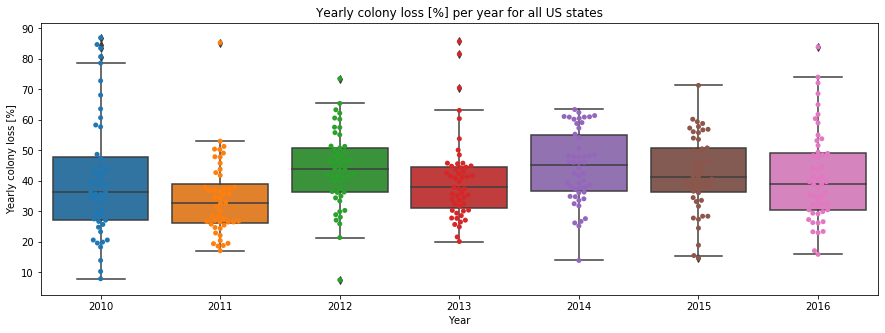

In [74]:
plt.figure(figsize=(15,5))
sns.boxplot(y='total annual loss', x='year', data=loss_all)
sns.swarmplot(y='total annual loss', x='year', data=loss_all)
plt.title('Yearly colony loss [%] per year for all US states')
plt.xlabel('Year')
plt.ylabel('Yearly colony loss [%]')

### Analysis:

In all the states, colonies are being lost. Between 2010 and 2016, the **median yearly colony loss** is roughly **stable**, albeit **very high** (~40). Additionally, we have a **lot of variance**, with values ranging from 10% to 90%.

## Average yearly loss of colonies [%] per State
#### 2010-2016


We see in the previous boxplot that the **yearly colony losses are well spread out** (with values ranging from 10 to 90%).

We now investigate how each state compares in terms of **average yearly loss of colonies**, to see if there are any major discrepancies.

In [75]:
loss_per_state = loss_all.groupby('state').mean().reset_index()


In [76]:
loss_per_state.replace(to_replace=states, inplace=True) 
loss_per_state.dropna(inplace=True)
loss_per_state['total annual loss'] *= 100

In [77]:
loss_per_state.head()

,state,year,total annual loss,beekeepers,beekeepers exclusive to state,colonies,colonies exclusive to state
0,AL,2013.0,3594.285714,32.000000,0.951857,645.142857,0.843571
2,AZ,2013.0,4061.428571,7.571429,0.829429,988.142857,0.475714
3,AR,2013.0,3764.285714,41.857143,0.926000,3188.285714,0.526143
4,CA,2013.0,3571.428571,187.428571,0.689857,380262.285714,0.136286
5,CO,2013.0,3844.285714,124.142857,0.975143,24208.714286,0.508857


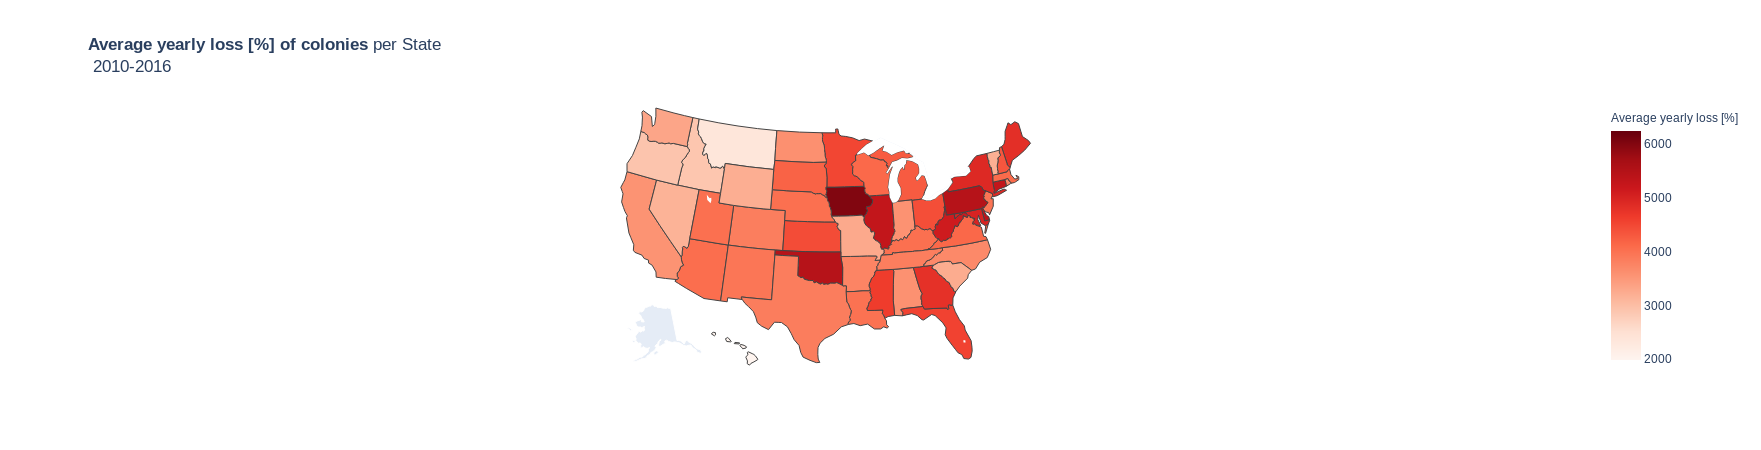

In [78]:
fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=loss_per_state['total annual loss'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average yearly loss [%]',
))

fig.update_layout(
    title_text = '<b>Average yearly loss [%] of colonies</b> per State <br> 2010-2016 ',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis

As we can see, the **average yearly loss** accross the US is **quite high**, and **affects all states**. There is however  **more colony loss on the east coast** than the west coast. 


## Average amount of colonies per State 
#### 2010-2016

We have seen where the bees are dying, but **where are they more located** ?
To answer this question, we plot the amount of colonies per state.

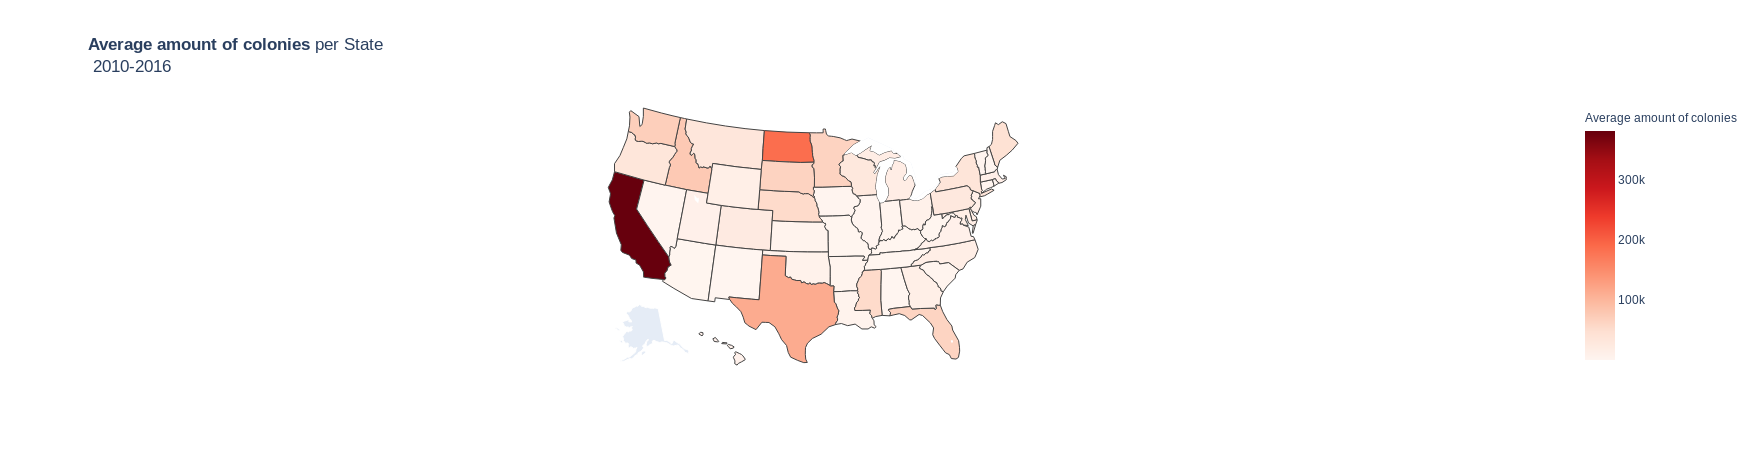

In [111]:
fig = go.Figure(data=go.Choropleth(
    locations=loss_per_state['state'],
    z=loss_per_state['colonies'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Average amount of colonies',
))

fig.update_layout(
    title_text = '<b>Average amount of colonies</b> per State <br> 2010-2016 ',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis

As we can see, **California** is by far the **state with the most colonies** (380k). This can be explained by **California's almond production**, representing more than **80% of the world's production**. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11) Almonds rely heavily on honeybees for their polinization. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421)

## Bee pests 

Now that we know where the bees are dying, and where they are located, we can start investigating one suspected culprit of the CCD : the bee pests.

In [80]:
varroa.head(3)

,year,period,state,value
3,2019,winter,AL,27.2
5,2019,winter,AZ,25.8
7,2019,winter,AR,19.5


In [81]:
non_varroa.head(3)

,year,period,state,value
2,2019,winter,AL,22.7
4,2019,winter,AZ,7.9
6,2019,winter,AR,1.5


## Varroa per season
#### 2015-2019

How does the fraction of colonies affected by the Varroa evolve throughout seasons ? 

Text(0, 0.5, 'Fraction of colonies affected the by Varroa [%]')

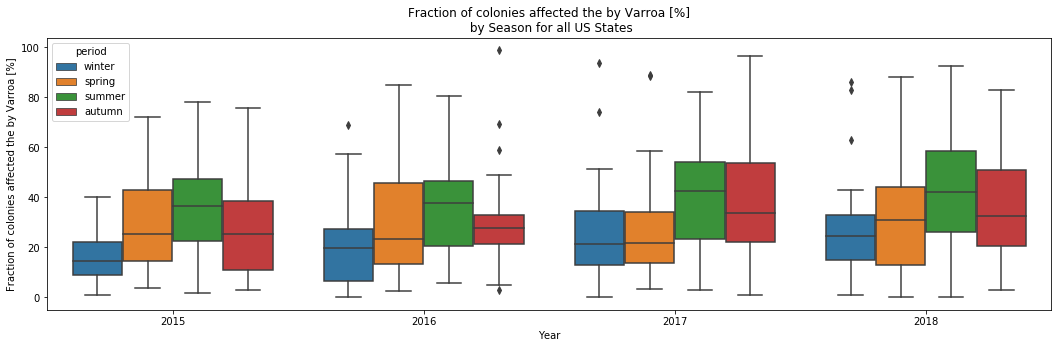

In [115]:
plt.figure(figsize=(18,5))
sns.boxplot(y='value', x='year', hue='period', data=varroa[varroa.year != 2019])
plt.title('Fraction of colonies affected the by Varroa [%]\n by Season for all US States')
plt.xlabel('Year')
plt.ylabel('Fraction of colonies affected the by Varroa [%]')

### Analysis

As we can see, the fraction of colonies infected increased from winter to summer before plummetting in automn. This makes sense since the Varroa is sensitive to the drop in temperature.

## Fraction of colonies affected by Varroa Mites in summer and winter
#### 2015-2019

We have now seen that the Varroa Mites are the most populous in summer, but how spread out is the Varroa throughout the US ?

To answer this, we plot the fraction of colonies affected by the Varroa when it is at both peaks, i.e. in summer and winter

In [103]:
varroa_summer = varroa[varroa.period == 'summer'].groupby('state').mean()['value'].reset_index()
varroa_winter = varroa[varroa.period == 'winter'].groupby('state').mean()['value'].reset_index()

varroa_summer.head(3)

,state,value
0,AL,55.450
1,AR,60.300
2,AZ,41.875


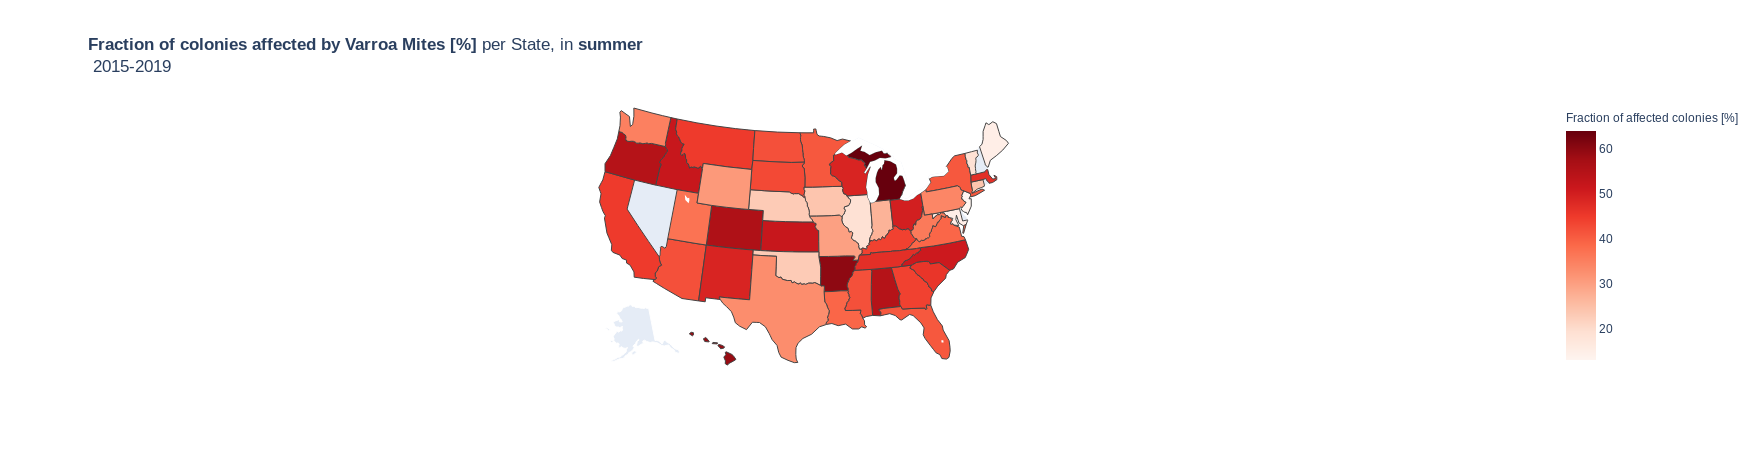

In [110]:
fig = go.Figure(data=go.Choropleth(
    locations=varroa_summer['state'],
    z=varroa_summer['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Fraction of affected colonies [%]',
))

fig.update_layout(
    title_text = '<b>Fraction of colonies affected by Varroa Mites [%]</b> per State, in <b>summer</b> <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

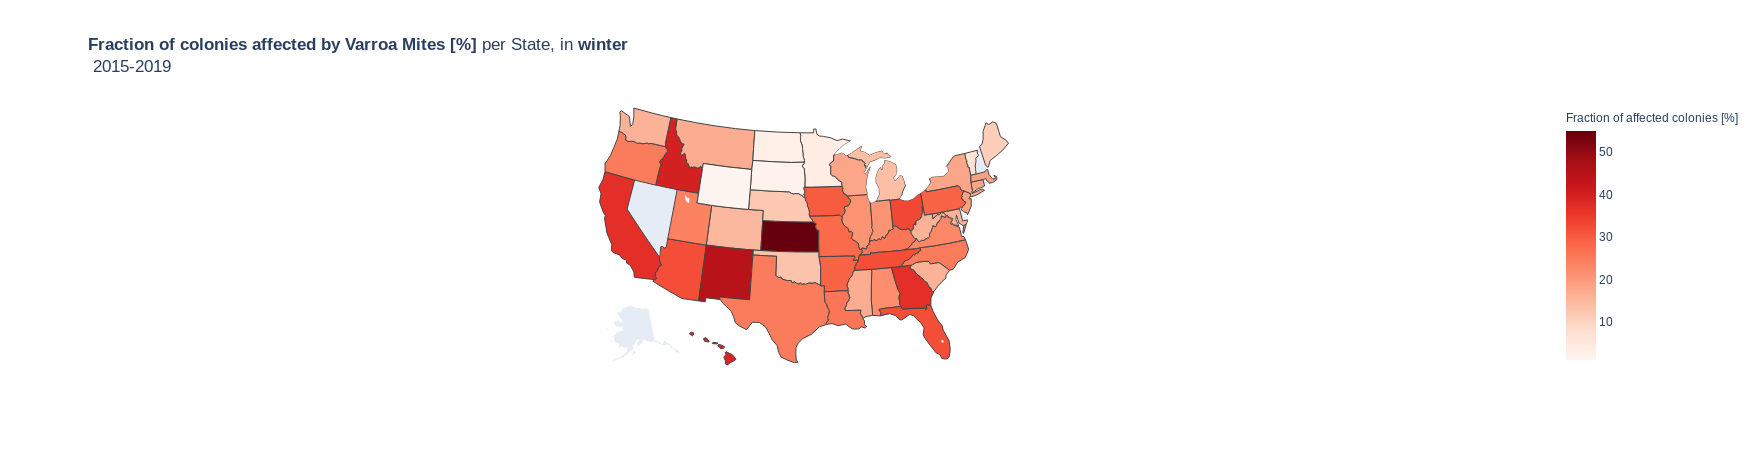

In [109]:
fig = go.Figure(data=go.Choropleth(
    locations=varroa_winter['state'],
    z=varroa_winter['value'].astype(float).apply(round),
    locationmode='USA-states',
    colorscale='Reds',
    colorbar_title='Fraction of affected colonies [%]',
))

fig.update_layout(
    title_text = '<b>Fraction of colonies affected by Varroa Mites [%]</b> per State, in <b>winter</b> <br> 2015-2019',
    geo_scope='usa', # limite map scope to USA
    dragmode=False
)

fig.show()

### Analysis 

Varroas are a **widespread problem**, affecting between 20 and 50% of all colonies within a state. 

In the **summer**, the Varroas of the North-East tend to die off, while the rest of the US maintains a high count of Varroas.

This is especially an issue since **California** is the **state with the most colonies** by far, and it also is one of the states with the most varroas per colonies in the winter.

Unfortunately, February to March is precisely when the almond trees bloom.

## What about the other pests ?

Varroas have been a hot-topic in the bee community, but what about other pests ? Are they as widespread and as endemic ?

In [106]:
non_varroa

,year,period,state,value
2,2019,winter,AL,22.7
4,2019,winter,AZ,7.9
6,2019,winter,AR,1.5
8,2019,winter,CA,13.4
10,2019,winter,CO,0.3
...,...,...,...,...
1601,2015,autumn,VA,17.2
1603,2015,autumn,WA,0.1
1605,2015,autumn,WV,4.5
1607,2015,autumn,WI,15.6


Text(0, 0.5, 'Fraction of colonies affected the by pest \n (excluding the Varroa) [%]')

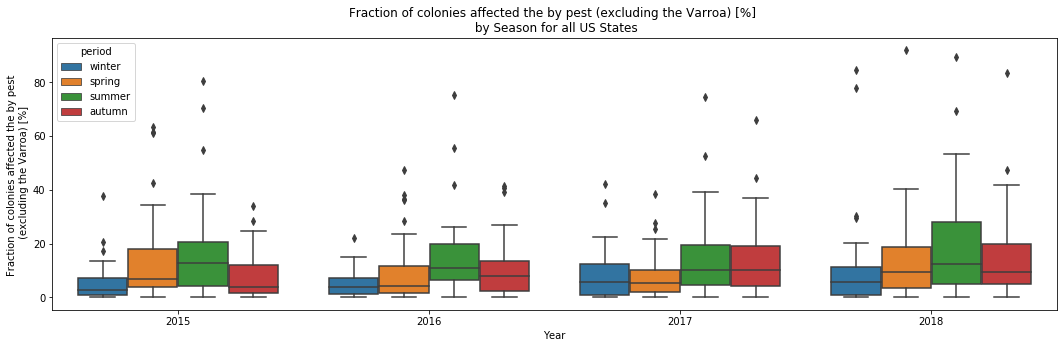

In [114]:
plt.figure(figsize=(18,5))
sns.boxplot(y='value', x='year', hue='period', data=non_varroa[non_varroa.year != 2019])
plt.title('Fraction of colonies affected the by pest (excluding the Varroa) [%] \n by Season for all US States')
plt.xlabel('Year')
plt.ylabel('Fraction of colonies affected the by pest \n (excluding the Varroa) [%]')

## Analysis 


Other pests follow the same patterns (i.e. growing from end of the winter to summer, and dying off in winter). Additionally, they are well widespread throughout the US. However, Varroas are more endemic, affecting far more beehives.

## 5. California accounts for 80% of the world almond production, what is the impact of bees on this industry in the 21st century?

Calfornia is responsible for more than 80% of the world almond production. [[1]](https://www.marketwatch.com/story/almond-crunch-california-drought-withers-world-supply-2014-03-11)
Almonds need honey bees to be polinized. [[2]](https://theconversation.com/a-bee-economist-explains-honey-bees-vital-role-in-growing-tasty-almonds-101421)

As we have seen above, **California** has an **average annual loss** of colonies of **36%**. 
What does this mean in terms of Almonds production ?


In [123]:
# As per the pdf from the USDA, the almond productions has tripled in the last 20 years. 
california_almond = pd.read_excel('data/california_USDA_almond.xlsx')
california_almond.head()

,year,bearing,non_bearing,yield_per_acre,production,price_per_pound,value_of_production
0,1997,442000,63000,1720,759,1.56,1160640.0
1,1998,460000,120000,1130,520,1.41,703590.0
2,1999,485000,115000,1720,833,0.86,687742.0
3,2000,510000,100000,1380,703,0.97,666487.0
4,2001,530000,75000,1570,830,0.91,740012.0


In [124]:
# Convert to kg
california_almond.yield_per_acre *= 0.453592
california_almond.production *= 0.453592


## Production of Californian almonds 
#### 1997-2017


Text(0, 0.5, 'Almond production\n [Million of kg]')

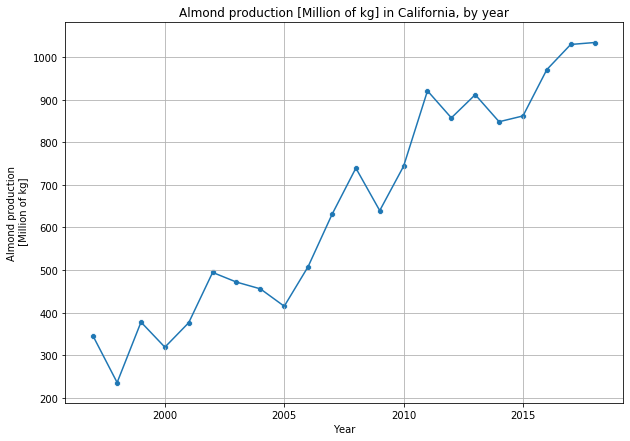

In [135]:
plt.figure(figsize=(10,7))
sns.lineplot(x='year', y='production', data=california_almond)
sns.scatterplot(x='year', y='production', data=california_almond)

plt.title('Almond production [Million of kg] in California, by year')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Almond production\n [Million of kg]')

Text(0, 0.5, 'Yield per acre [kg/acre]')

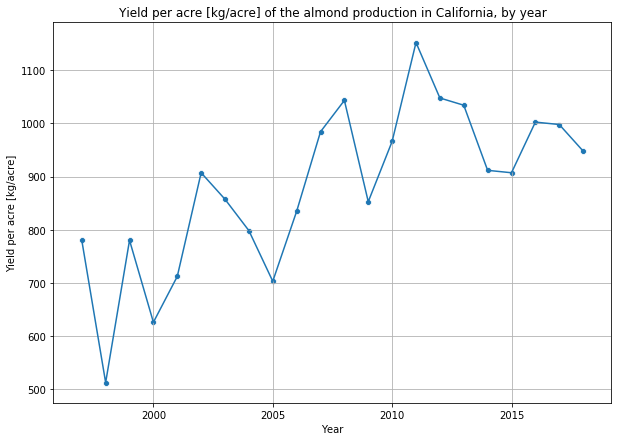

In [134]:
plt.figure(figsize=(10,7))
sns.lineplot(x='year', y='yield_per_acre', data=california_almond)
sns.scatterplot(x='year', y='yield_per_acre', data=california_almond)

plt.title('Yield per acre [kg/acre] of the almond production in California, by year')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Yield per acre [kg/acre]')

### Analysis

As we can see, the death of bees has not prevented the Californian almond industry to increase its production, as well as the amount of almonds produced per area.

This is due to the fact that bees are imported.